# Recurrent Neural Network

Modified from Tensorflow time series example

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### Read csv raw data

In [216]:
df=pd.read_csv('simple_well_noise3.csv')

Let's take a glance at the data.

In [217]:
df.head()

,Date,Gas Flow_MMSCFD,Oil_bpd,Water_bpd,FWHP_psig,FroudeNumberGas6,FroudeNumberLiquid6,HoldupFractionLiquid6,ReynoldsNumber6,SuperficialVelocityGas6,SuperficialVelocityLiquid6,SurfaceTensionLiquidInSitu6,ViscosityLiquidInSitu6,FlowPatternGasLiquid6,FINAPRESS,FINATEMP
0,1/1/2020,2.002,442.2,4589.139400,5714.6,0.081595,0.839249,0.845649,413949.5027,0.511382,2.653231,0.012656,0.273348,4,2218.335761,212.651966
1,1/2/2020,1.937,423.2,4049.393707,5706.3,0.079080,0.752242,0.836687,371353.2559,0.490838,2.372266,0.012323,0.274702,4,2258.367024,211.128585
2,1/3/2020,1.922,413.6,3596.768652,5487.4,0.082463,0.668271,0.810318,343398.8686,0.532550,2.128514,0.013427,0.276586,4,2132.427828,209.239809
3,1/4/2020,1.988,419.2,3261.638877,5458.9,0.086243,0.619788,0.792928,322576.7052,0.550711,1.968633,0.013022,0.277707,4,2178.909530,207.699399
4,1/5/2020,1.978,407.6,2999.843801,5332.9,0.088403,0.571403,0.773257,306047.9193,0.575918,1.823825,0.013569,0.279261,4,2119.901822,206.199223


In [218]:
df.drop(columns='Date', inplace=True)

In [219]:
df2=pd.get_dummies(df['FlowPatternGasLiquid6'],prefix='FlowPattern')

In [220]:
df=pd.concat([df,df2],axis=1)

In [221]:
df.drop(columns='FlowPatternGasLiquid6', inplace=True)

In [222]:
df.head()

,Gas Flow_MMSCFD,Oil_bpd,Water_bpd,FWHP_psig,FroudeNumberGas6,FroudeNumberLiquid6,HoldupFractionLiquid6,ReynoldsNumber6,SuperficialVelocityGas6,SuperficialVelocityLiquid6,SurfaceTensionLiquidInSitu6,ViscosityLiquidInSitu6,FINAPRESS,FINATEMP,FlowPattern_3,FlowPattern_4
0,2.002,442.2,4589.139400,5714.6,0.081595,0.839249,0.845649,413949.5027,0.511382,2.653231,0.012656,0.273348,2218.335761,212.651966,0,1
1,1.937,423.2,4049.393707,5706.3,0.079080,0.752242,0.836687,371353.2559,0.490838,2.372266,0.012323,0.274702,2258.367024,211.128585,0,1
2,1.922,413.6,3596.768652,5487.4,0.082463,0.668271,0.810318,343398.8686,0.532550,2.128514,0.013427,0.276586,2132.427828,209.239809,0,1
3,1.988,419.2,3261.638877,5458.9,0.086243,0.619788,0.792928,322576.7052,0.550711,1.968633,0.013022,0.277707,2178.909530,207.699399,0,1
4,1.978,407.6,2999.843801,5332.9,0.088403,0.571403,0.773257,306047.9193,0.575918,1.823825,0.013569,0.279261,2119.901822,206.199223,0,1


In [223]:
y_pre=df['FINAPRESS']      # Pressure label
X_pre=df.drop(columns=['FINAPRESS','FINATEMP'], axis=1) # Pressure data

In [224]:
y_hol=df['HoldupFractionLiquid6']     # holdup label
X_hol=df.drop(columns=['HoldupFractionLiquid6','FINATEMP'], axis=1)    # hold up data

In [304]:
X=df.iloc[:, 0:16]
y=df.iloc[:, 12]

In [305]:
y.head()

0    2218.335761
1    2258.367024
2    2132.427828
3    2178.909530
4    2119.901822
Name: FINAPRESS, dtype: float64

### Plot the raw data

In [306]:
def four_y_plot(paraa, labela, parab, labelb, parac, labelc, parad, labeld, labelx, title):
    def make_patch_spines_invisible(ax):
        ax.set_frame_on(True)
        ax.patch.set_visible(False)
        for sp in ax.spines.values():
            sp.set_visible(False)
    
    fig, host = plt.subplots(figsize=(10, 8))
    fig.subplots_adjust(right=1)
    
    par1 = host.twinx()
    par2 = host.twinx()
    par3 = host.twinx()

    # Offset the right spine of par2.  The ticks and label have already been
    # placed on the right by twinx above.
    par2.spines["right"].set_position(("axes", 1.1))
    par3.spines["right"].set_position(("axes", 1.2))
    # Having been created by twinx, par2 has its frame off, so the line of its
    # detached spine is invisible.  First, activate the frame but make the patch
    # and spines invisible.
    make_patch_spines_invisible(par2)
    make_patch_spines_invisible(par3)
    # Second, show the right spine.
    par2.spines["right"].set_visible(True)
    par3.spines["right"].set_visible(True)
    
    p1, = host.plot(paraa, "b-", label=labela)
    p2, = par1.plot(parab, "r-", label=labelb)
    p3, = par2.plot(parac, "g-", label=labelc)
    p4, = par3.plot(parad, "black", label=labeld)
    
    # host.set_xlim(0, 250)
    # host.set_ylim(0, 2.2)
    # par1.set_ylim(0, 500)
    # par2.set_ylim(1, 5000)
    # par3.set_ylim(1, 6000)
    
    host.set_xlabel(labelx, fontsize=14)
    host.set_ylabel(labela, fontsize=14)
    par1.set_ylabel(labelb, fontsize=14)
    par2.set_ylabel(labelc, fontsize=14)
    par3.set_ylabel(labeld, fontsize=14)
    
    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())
    par3.yaxis.label.set_color(p4.get_color())
    
    tkw = dict(size=4, width=1.5)
    host.tick_params(axis='y', colors=p1.get_color(), labelsize=12)
    par1.tick_params(axis='y', colors=p2.get_color(), labelsize=12)
    par2.tick_params(axis='y', colors=p3.get_color(), labelsize=12)
    par3.tick_params(axis='y', colors=p4.get_color(), labelsize=12)
    host.tick_params(axis='x', labelsize=14)
 
    lines = [p1, p2, p3, p4]
    
    host.legend(lines, [l.get_label() for l in lines], fontsize=14)
    plt.title(title, fontsize=16)
    
    plt.show()
    

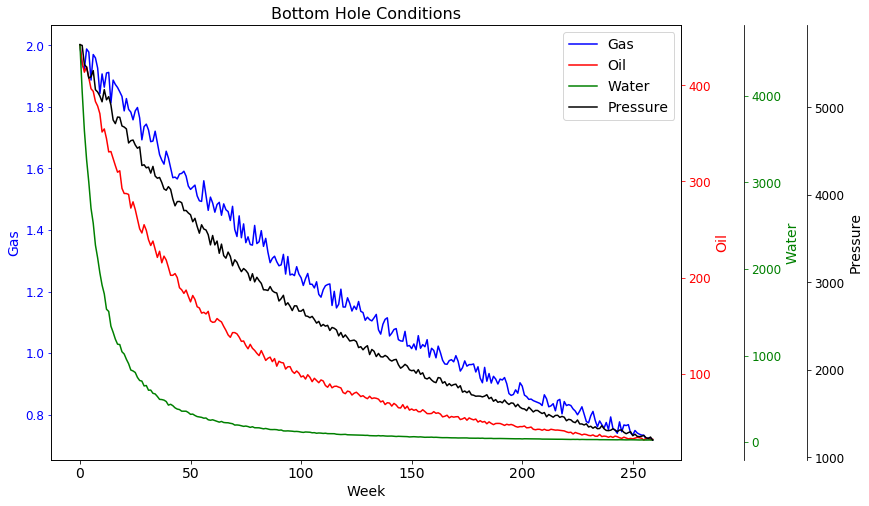

In [228]:
four_y_plot(df['Gas Flow_MMSCFD'], "Gas",
            df['Oil_bpd'], "Oil", 
            df['Water_bpd'],"Water",
            df['FWHP_psig'], "Pressure",
            "Week",
            "Bottom Hole Conditions")

### Reshape the input data

In both the following, the first 180 rows of the data will be the training dataset, and there remaining will be the validation dataset. 

In [307]:
TRAIN_VAL = 170   #train and validation split
VAL_TEST=212      #validation and test split

Setting seed to ensure reproducibility.

In [308]:
tf.random.set_seed(13)

Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [309]:
def create_time_steps(length):
  return list(range(-length, 0))

In [310]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i]) 
      #flattren() remove one layer of list'[]'
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

### Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be *the average of the last 20 observations*.

In [311]:
def baseline(history):
  return np.mean(history)

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the [RNN tutorial](https://www.tensorflow.org/tutorials/sequences/recurrent). In this tutorial, you will use a specialized RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM))

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

## Forecast a multivariate time series

In [52]:
features = X_pre
# features.index = df['Date Time']
features.head()

,Gas Flow_MMSCFD,Oil_bpd,Water_bpd,FWHP_psig,FroudeNumberGas6,FroudeNumberLiquid6,HoldupFractionLiquid6,ReynoldsNumber6,SuperficialVelocityGas6,SuperficialVelocityLiquid6,SurfaceTensionLiquidInSitu6,ViscosityLiquidInSitu6,FlowPattern_3,FlowPattern_4
0,2.002,442.2,4589.139400,5714.6,0.081595,0.839249,0.845649,413949.5027,0.511382,2.653231,0.012656,0.273348,0,1
1,1.937,423.2,4049.393707,5706.3,0.079080,0.752242,0.836687,371353.2559,0.490838,2.372266,0.012323,0.274702,0,1
2,1.922,413.6,3596.768652,5487.4,0.082463,0.668271,0.810318,343398.8686,0.532550,2.128514,0.013427,0.276586,0,1
3,1.988,419.2,3261.638877,5458.9,0.086243,0.619788,0.792928,322576.7052,0.550711,1.968633,0.013022,0.277707,0,1
4,1.978,407.6,2999.843801,5332.9,0.088403,0.571403,0.773257,306047.9193,0.575918,1.823825,0.013569,0.279261,0,1


In [53]:
X_pre.dtypes

Gas Flow_MMSCFD                float64
Oil_bpd                        float64
Water_bpd                      float64
FWHP_psig                      float64
FroudeNumberGas6               float64
FroudeNumberLiquid6            float64
HoldupFractionLiquid6          float64
ReynoldsNumber6                float64
SuperficialVelocityGas6        float64
SuperficialVelocityLiquid6     float64
SurfaceTensionLiquidInSitu6    float64
ViscosityLiquidInSitu6         float64
FlowPattern_3                    uint8
FlowPattern_4                    uint8
dtype: object

Let's have a look at how each of these features vary across time.

As mentioned, the first step will be to standardize the dataset using the mean and standard deviation of the training data.

In [197]:
dataset = features.values
data_mean = dataset[:TRAIN_VAL].mean(axis=0)
data_std = dataset[:TRAIN_VAL].std(axis=0)

In [312]:
dataset = X.values
data_mean = dataset[:TRAIN_VAL].mean(axis=0)
data_std = dataset[:TRAIN_VAL].std(axis=0)

In [342]:
data_mean

array([1.38553529e+00, 1.53708235e+02, 4.49985930e+02, 3.19311588e+03,
       8.44969174e-02, 1.09720236e-01, 4.29068159e-01, 9.19446085e+04,
       6.80424111e-01, 3.53352666e-01, 1.47673153e-02, 4.54247739e-01,
       1.40301186e+03, 1.16795001e+02, 7.05882353e-01, 2.94117647e-01])

In [313]:
dataset = (dataset-data_mean)/data_std

### Single step model (Predict current sequence '0' only, 'Future target' is 0)
In a single step setup, the model learns to predict a single point in the future based on some history provided.



In [314]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In this tutorial, the network is shown data from the last five (5) days, i.e. 720 observations that are sampled every hour. The sampling is done every one hour since a drastic change is not expected within 60 minutes. Thus, 120 observation represent history of the last five days.  For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. In order to create a label for this, the temperature after 72(12*6) observations is used.

In [315]:
past_history = 7
future_target = 0   # predict current. use 'past_history' points
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:,12], 0,
                                                   TRAIN_VAL, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:,12],
                                               TRAIN_VAL, VAL_TEST, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [366]:
x_test_single, y_test_single = multivariate_data(dataset, dataset[:,12],
                                               VAL_TEST, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Let's look at a single data-point.


In [350]:
y_test_single

array([-1.92614941, -1.96605113, -1.94899227, -1.95526021, -1.98209282,
       -1.99115946, -1.98287952, -1.99797799, -1.99101353, -2.01391285,
       -2.02394123, -2.04902102, -2.02733108, -2.02924425, -2.04219777,
       -2.0690977 , -2.050038  , -2.04188737, -2.06954081, -2.065827  ,
       -2.08297497, -2.04972734, -2.06943078, -2.08171729, -2.09639292,
       -2.06287408, -2.08419407, -2.079129  , -2.08885656, -2.0825451 ,
       -2.09704433, -2.12429231, -2.10360661, -2.11856482, -2.12212803,
       -2.12355418, -2.11790377, -2.13703165, -2.1402767 , -2.13405108,
       -2.15142771])

In [317]:
x_train_single.shape

(163, 7, 16)

In [318]:
y_train_single.shape

(163,)

In [319]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (7, 16)


In [320]:
BATCH_SIZE = 10
BUFFER_SIZE = 60

In [321]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [322]:
x_train_single.shape

(163, 7, 16)

In [386]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(128,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(128))
single_step_model.add(tf.keras.layers.Dense(128))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mae')

Let's check out a sample prediction.

In [324]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(10, 1)


In [370]:
EVALUATION_INTERVAL = 200
EPOCHS = 20

In [387]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 10s 49ms/step - loss: 0.0978 - val_loss: 0.0386
Epoch 2/20
200/200 [==============================] - 4s 21ms/step - loss: 0.0769 - val_loss: 0.1411
Epoch 3/20
200/200 [==============================] - 4s 22ms/step - loss: 0.0639 - val_loss: 0.0508
Epoch 4/20
200/200 [==============================] - 4s 22ms/step - loss: 0.0635 - val_loss: 0.3321
Epoch 5/20
200/200 [==============================] - 4s 22ms/step - loss: 0.0700 - val_loss: 0.1080
Epoch 6/20
200/200 [==============================] - 4s 22ms/step - loss: 0.0653 - val_loss: 0.0192
Epoch 7/20
200/200 [==============================] - 4s 22ms/step - loss: 0.0573 - val_loss: 0.0846
Epoch 8/20
200/200 [==============================] - 4s 22ms/step - loss: 0.0561 - val_loss: 0.1590
Epoch 9/20
200/200 [==============================] - 4s 22ms/step - loss: 0.0577 - val_loss: 0.1521
Epoch 10/20
200/200 [==========================

In [327]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

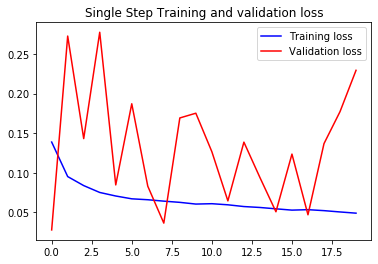

In [372]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step 


(10, 7, 16) (10,)


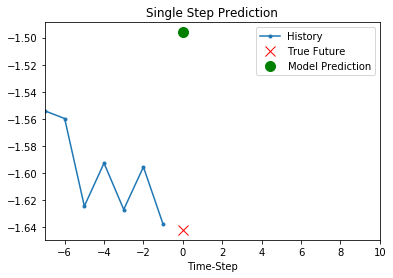

(10, 7, 16) (10,)


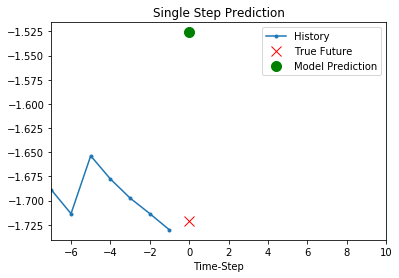

(10, 7, 16) (10,)


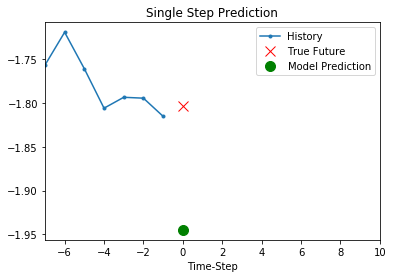

In [359]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[1][:, 12].numpy(), y[1].numpy(),
                    single_step_model.predict(x)[1]], 0,
                   'Single Step Prediction')
  print(x.shape, y.shape)
  plot.show()

In [388]:
predictions=single_step_model.predict(x_test_single)

In [389]:
predictions=predictions*data_std[12]+data_mean[12]

In [367]:
y_test_single=y_test_single*data_std[12]+data_mean[12]

In [335]:
from sklearn import metrics

def RNN_comp_plot(dnn, testy, pred, labelx, labely, ftitle):
    # Look at the results
    lw = 2
    
    fig= plt.figure(figsize=(12, 10))
   
    y_hat=predictions
        
    MAE=format(metrics.mean_absolute_error(testy, y_hat),'.3f')
    MSE=format(metrics.mean_squared_error(testy, y_hat),'.2f')
    R2=format(metrics.r2_score(testy, y_hat),'.4f')        
        
    plt.plot(y_hat, color='blue', lw=lw,
                      label='{} (MAE: {},  R^2: {})'.format(dnn, MAE, R2))
    plt.plot(testy, color='red', linestyle=':', lw=3,
                      label='Test data')                    
    plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.1),fontsize=12)
    plt.xlabel(labelx, fontsize=12)
    plt.ylabel(labely, fontsize=12)
    fig.suptitle(ftitle, fontsize=16)
    plt.show()

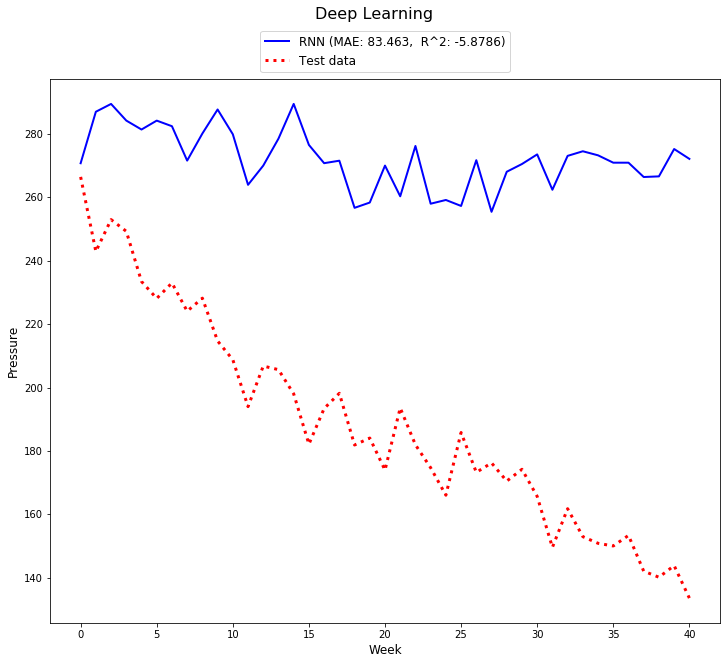

In [390]:
RNN_comp_plot("RNN",
             y_test_single,
             predictions,
             "Week",
             "Pressure",
             "Deep Learning")

### Multi-Step model (Predict future sequence '0','1'....)
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [160]:
future_target = 3
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 3], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 3],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

Let's check out a sample data-point.

In [161]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target pressure to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (7, 4)

 Target pressure to predict : (3,)


In [162]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [163]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In this plot and subsequent similar plots

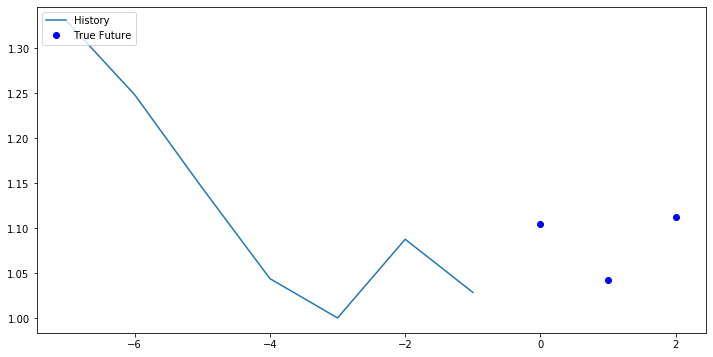

In [164]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [165]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(3))   # Predict 3 steps, which is 'future target' 

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it trains.

In [166]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(10, 3)


In [167]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 12s 62ms/step - loss: 0.1547 - val_loss: 0.0386
Epoch 2/10
200/200 [==============================] - 5s 24ms/step - loss: 0.0478 - val_loss: 0.0765
Epoch 3/10
200/200 [==============================] - 5s 25ms/step - loss: 0.0477 - val_loss: 0.0676
Epoch 4/10
200/200 [==============================] - 5s 25ms/step - loss: 0.0463 - val_loss: 0.0691
Epoch 5/10
200/200 [==============================] - 5s 24ms/step - loss: 0.0455 - val_loss: 0.1117
Epoch 6/10
200/200 [==============================] - 5s 25ms/step - loss: 0.0443 - val_loss: 0.0419
Epoch 7/10
200/200 [==============================] - 5s 27ms/step - loss: 0.0450 - val_loss: 0.0877
Epoch 8/10
200/200 [==============================] - 5s 26ms/step - loss: 0.0430 - val_loss: 0.0471
Epoch 9/10
200/200 [==============================] - 5s 25ms/step - loss: 0.0426 - val_loss: 0.0244
Epoch 10/10
200/200 [==========================

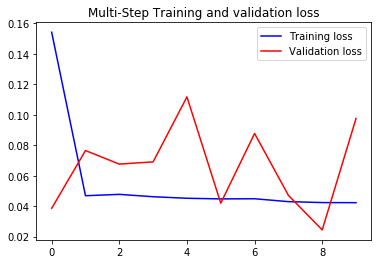

In [168]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

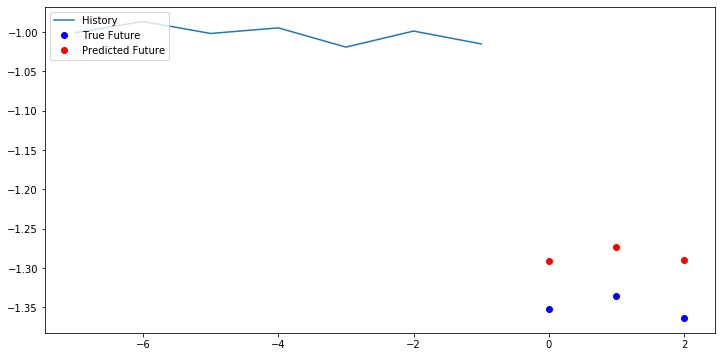

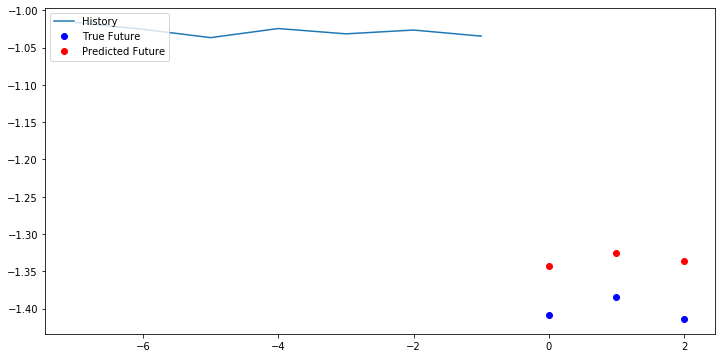

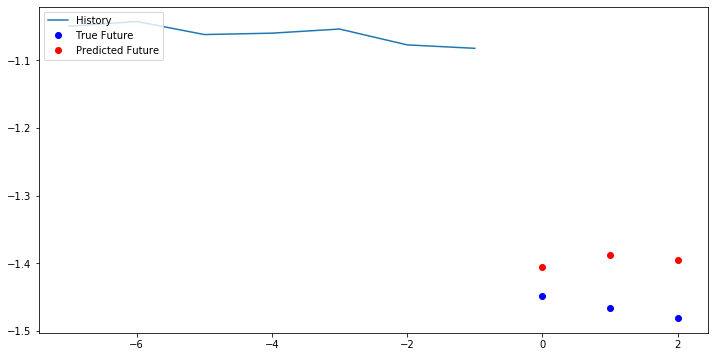

In [169]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])